In [1]:
import numpy as np                        
from sklearn.decomposition import PCA     
from sklearn.manifold import TSNE         
from umap import UMAP               
import matplotlib.pyplot as plt           
from SERGIO.SERGIO.sergio import sergio   
from time import time
from numpy_simulator import Sim

np.random.seed(123)
%matplotlib inline

from jit_simulator import Sim as jax_sim

In [2]:
interactions_filename = 'SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Interaction_cID_4.txt'
regulators_filename = 'SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Regs_cID_4.txt'
select_genes_to_visualize =  [84, 93, 62, 67, 17, 56, 44,] # [1, 74, 14,

## <span style="color:green">**running simulators (deterministic)**</span>

In [3]:
start=time()
jaxsim = jax_sim(num_genes=100, num_cells_types=9, num_cells_to_simulate=6, deterministic=True)
jaxsim.run()
x_jax_counts = jaxsim.x
print(x_jax_counts.shape)
print(f"took {time() - start:.4f} seconds")

sampling time steps:  300
(300, 100, 9)
took 17.7789 seconds


In [8]:
start = time()
sim_sergio = sergio(number_genes=100,
                 number_bins=9,
                 number_sc=300,
                 noise_params=1,
                 decays=0.8,
                 sampling_state=1,
                 noise_type="dpd",
                 deterministic=True)
sim_sergio.build_graph( 
        input_file_taregts=interactions_filename, input_file_regs=regulators_filename, shared_coop_state=2)
sim_sergio.simulate()
sergio_deterministic_clean_expression = sim_sergio.getExpressions()
print(sergio_deterministic_clean_expression.shape)
print(f"took {time() - start:.4f} seconds") # Took 120.8914 sec.

Start simulating new level
There are 4 genes to simulate in this layer
Done with current level
Start simulating new level
There are 6 genes to simulate in this layer
Done with current level
Start simulating new level
There are 90 genes to simulate in this layer
Done with current level
(9, 100, 300)
took 6.9338 seconds


In [9]:
start = time()
np_sim_deterministic = Sim(num_genes=100, num_cells_types=9, num_cells_to_simulate=20, interactions=interactions_filename, regulators=regulators_filename, deterministic=True)
np_sim_deterministic.run()
expr_np_sim_deterministic = np_sim_deterministic.x
print(expr_np_sim_deterministic.shape)
print(f"took {time() - start:.4f} seconds")

sampling time steps:  300
(300, 100, 9)
took 0.9629 seconds


## <span style="color:green">**checking deterministic trajectories**</span>

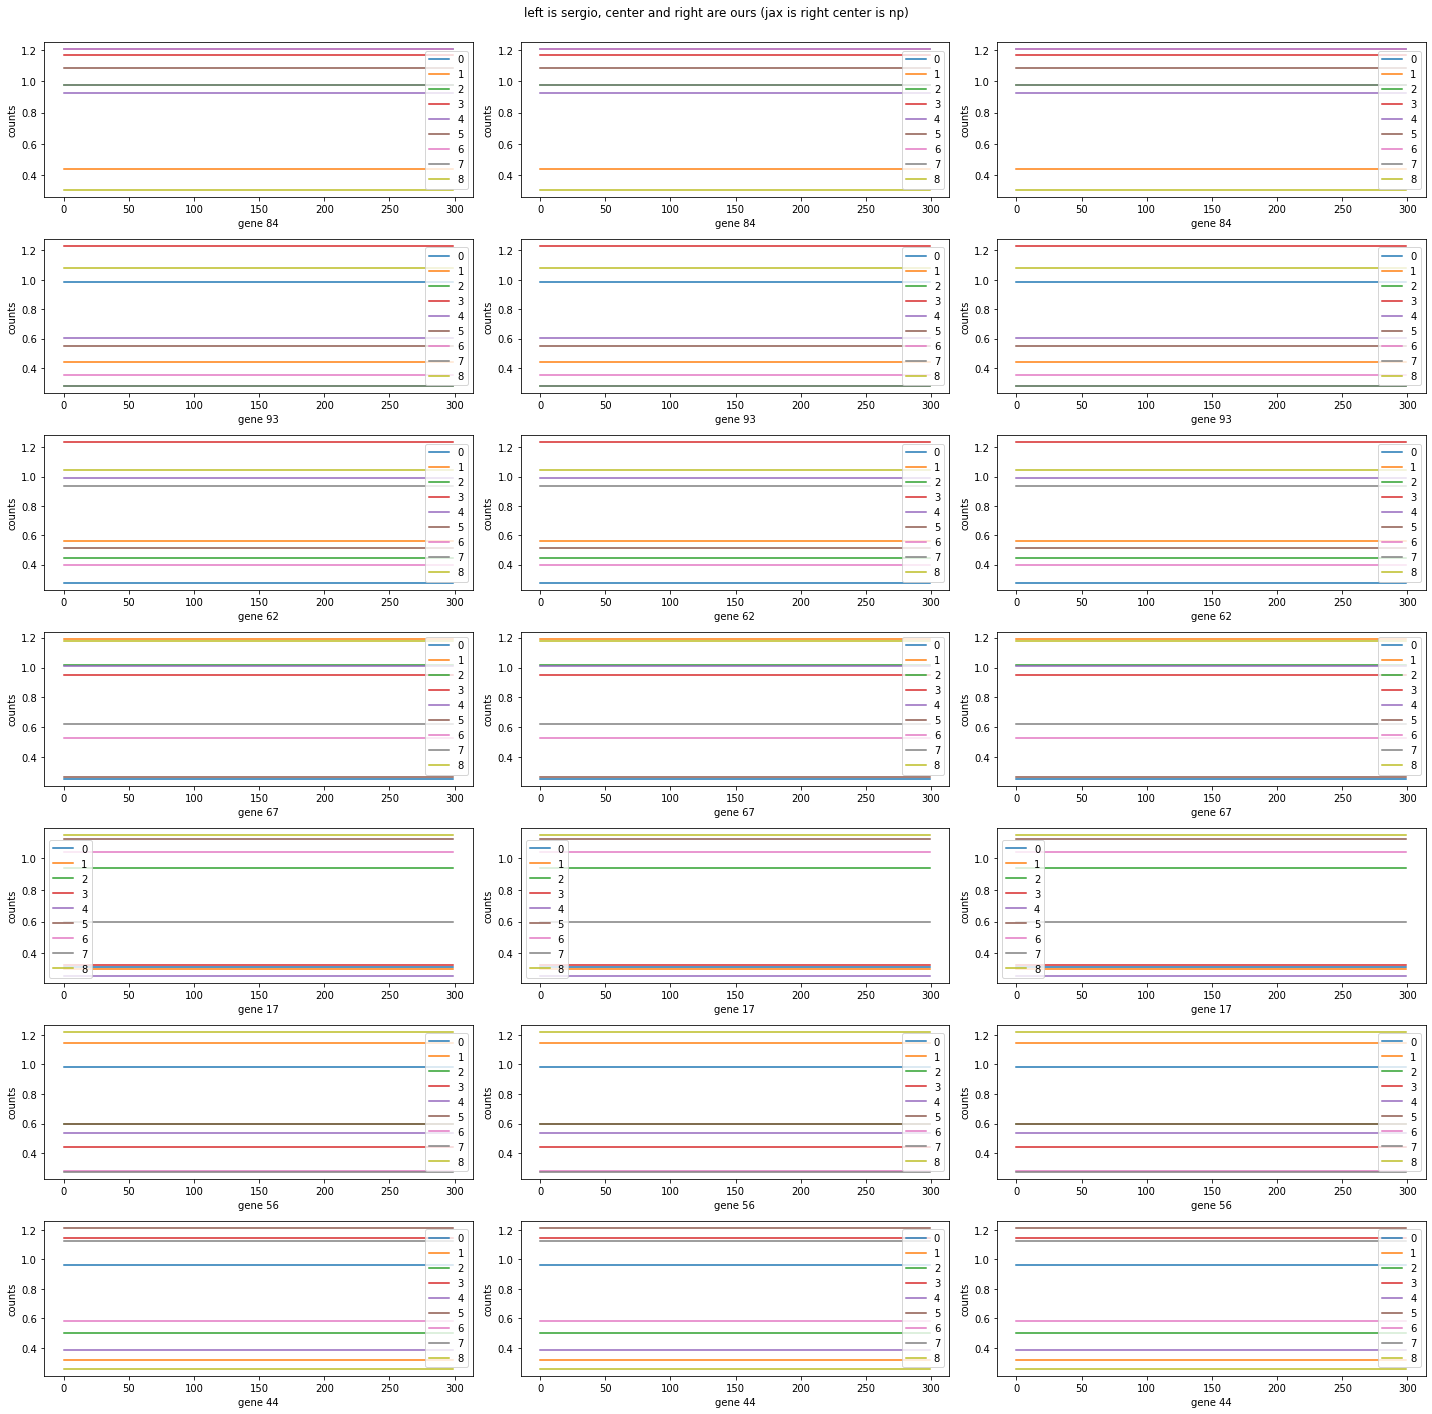

In [13]:
figure, axis = plt.subplots(len(select_genes_to_visualize), 3, figsize=(20, 20))
for ax, gene_id in enumerate(select_genes_to_visualize): 
    for implementation, counts in enumerate([sergio_deterministic_clean_expression, expr_np_sim_deterministic.T, x_jax_counts.T]):
        for cell_type in range(9):
            axis[ax, implementation].plot(counts[cell_type,gene_id,:], label=cell_type)
            axis[ax, implementation].set_xlabel(f"gene {gene_id}")
            axis[ax, implementation].set_ylabel(f"counts")
            axis[ax, implementation].legend()
plt.suptitle('left is sergio, center and right are ours (jax is right center is np)\n\n')
plt.tight_layout()

## <span style="color:blue">running simulators with noise</span>

In [9]:
start = time()
sim_sergio_not_deterministic = sergio(number_genes=100,
                 number_bins=9,
                 number_sc=300,
                 noise_params=1,
                 decays=0.8,
                 sampling_state=15,
                 noise_type="dpd",
                 deterministic=False)
sim_sergio_not_deterministic.build_graph(input_file_taregts=interactions_filename, input_file_regs=regulators_filename, shared_coop_state=2)
sim_sergio_not_deterministic.simulate()
sergio_not_deterministic_clean_expression = sim_sergio_not_deterministic.getExpressions()
print(sergio_not_deterministic_clean_expression.shape)
print(f"took {time() - start:.4f} seconds")

Start simulating new level
There are 4 genes to simulate in this layer
Done with current level
Start simulating new level
There are 6 genes to simulate in this layer
Done with current level
Start simulating new level
There are 90 genes to simulate in this layer
Done with current level
(9, 100, 300)
took 111.8858 seconds


In [6]:
start = time()
np_sim_not_deterministic = Sim(num_genes=100, num_cells_types=9, num_cells_to_simulate=300, interactions=interactions_filename, regulators=regulators_filename, deterministic=False)
np_sim_not_deterministic.run()
expr_np_sim_not_deterministic = np_sim_not_deterministic._x
print(expr_np_sim_not_deterministic.shape)
print(f"took {time() - start:.4f} seconds")

sampling time steps:  4500
(300, 100, 9)
took 13.8223 seconds


In [12]:
start=time()
jaxsim = jax_sim(num_genes=100, num_cells_types=9, num_cells_to_simulate=6) #, deterministic=False)
jaxsim.run(np.random.normal(size=(100000, 9)))
x_jax_counts_not_deterministic = jaxsim.x
print(x_jax_counts_not_deterministic.shape)
print(f"took {time() - start:.4f} seconds")

sampling time steps:  300


/home/ionelia/.local/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:6635: FutureWarning: `a_min` and `a_max` keyword arguments to ndarray.clip are deprecated in favor of `min` and `max` for compatibility with numpy. They will be removed in JAX 0.22.2
  warnings.warn('`a_min` and `a_max` keyword arguments to ndarray.clip are deprecated '


(300, 100, 9)
took 15.5644 seconds


## <span style="color:blue">checking noisy trajectories</span>

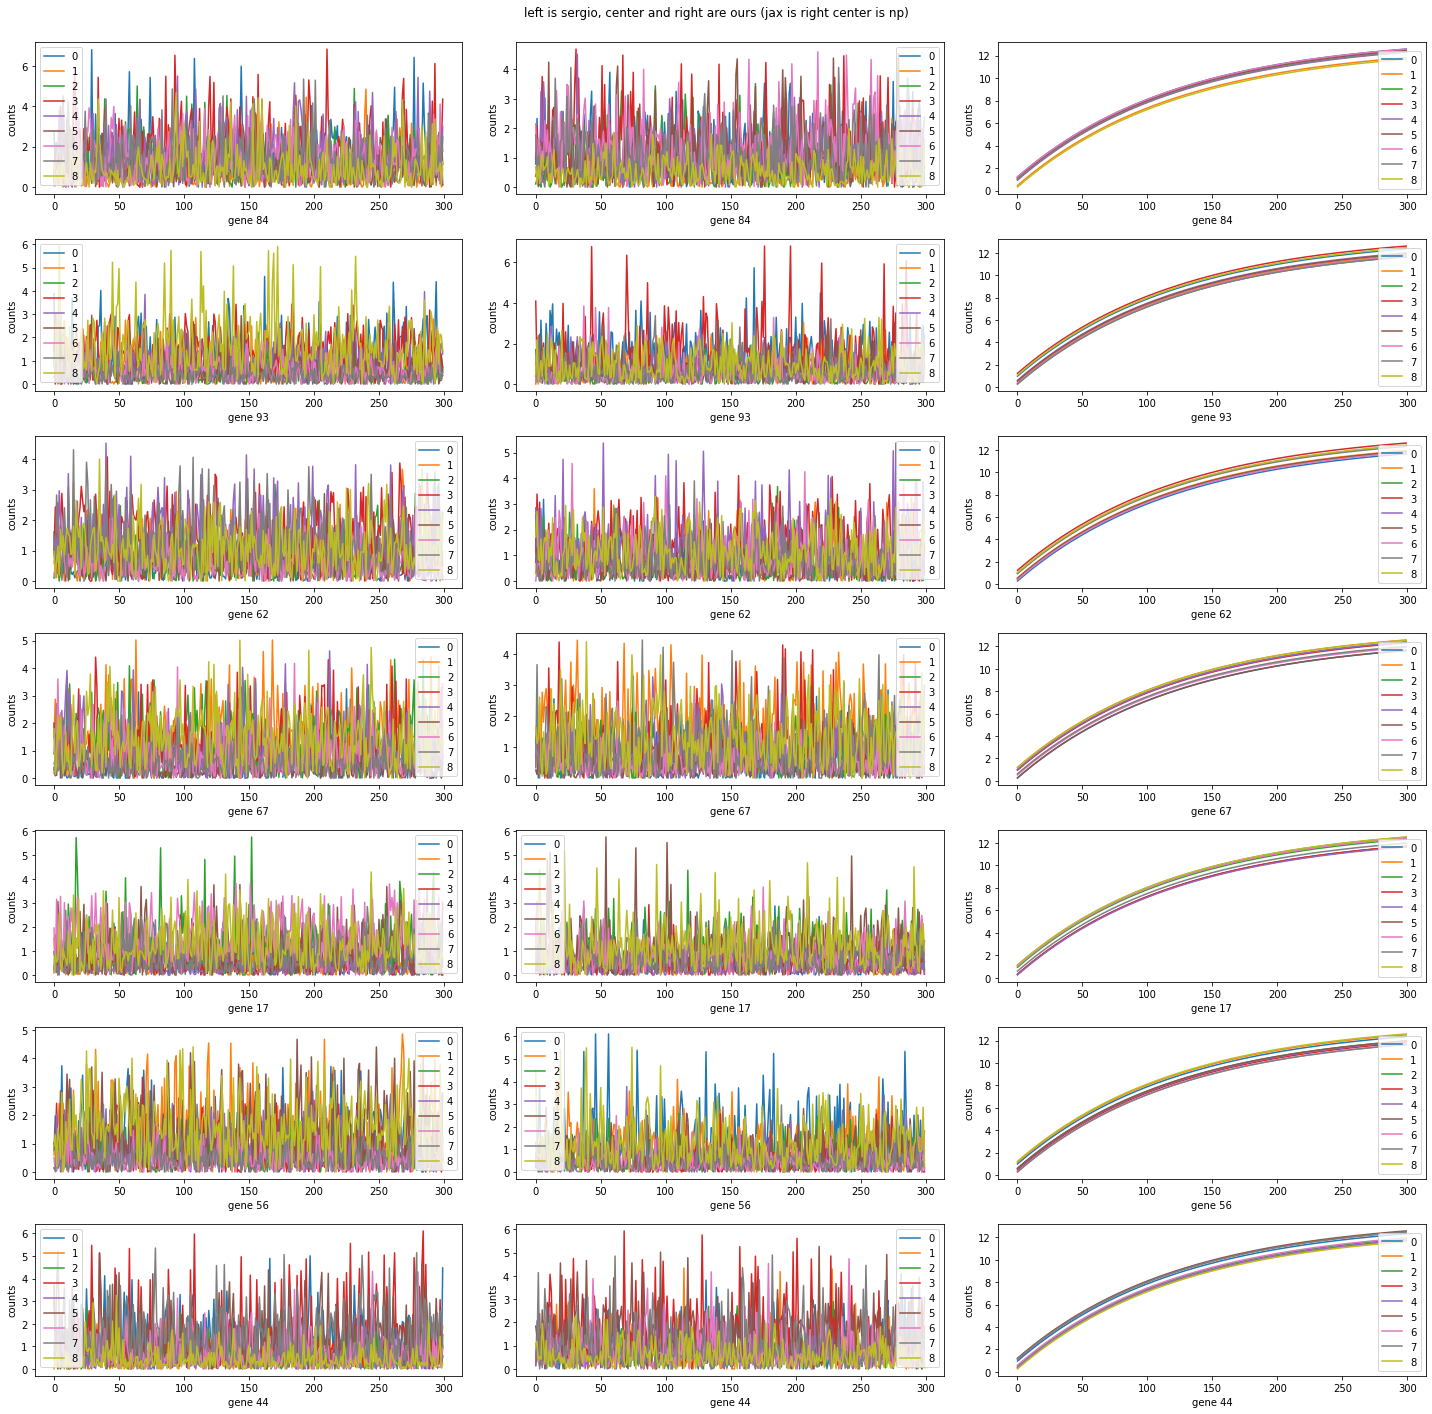

In [15]:
figure, axis = plt.subplots(len(select_genes_to_visualize), 3, figsize=(20, 20))
for ax, gene_id in enumerate(select_genes_to_visualize): 
    for implementation, counts in enumerate([sergio_not_deterministic_clean_expression, expr_np_sim_not_deterministic.T, x_jax_counts_not_deterministic.T]):
        for cell_type in range(9):
            axis[ax, implementation].plot(counts[cell_type,gene_id,:], label=cell_type)
            axis[ax, implementation].set_xlabel(f"gene {gene_id}")
            axis[ax, implementation].set_ylabel(f"counts")
            axis[ax, implementation].legend()
plt.suptitle('left is sergio, center and right are ours (jax is right center is np)\n\n')
plt.tight_layout()

key bug

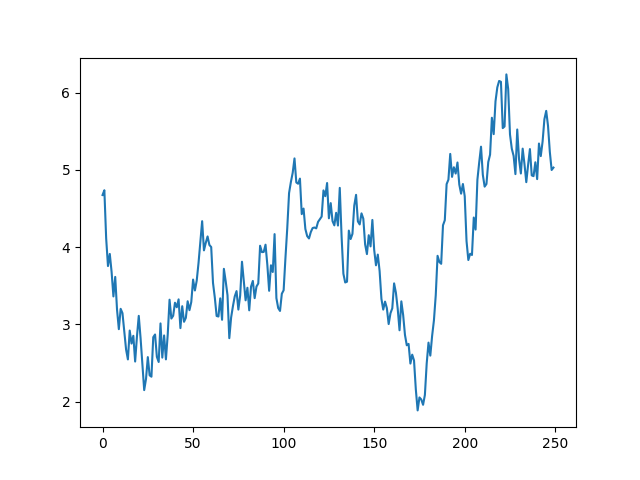

In [ ]:
layer:  0
-5.365470956421566 -9.801367737224849
-8.635100784843585 -0.06538427643469011
2.691298271089786 -1.1483062970971996

## some other analysis

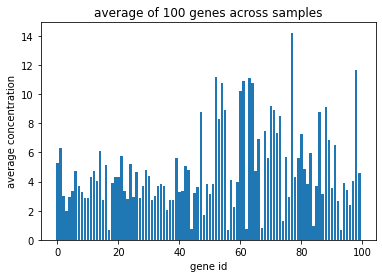

In [26]:
count_clean_sergio = np.concatenate(clean_expression, axis = 1).T # shape=(#samples, #genes)
# log_count_clean_sergio = np.log1p(count_clean_sergio)
genes_means = count_clean_sergio.mean(axis=0)

plt.bar([i for i in range(100)], genes_means)
plt.title("average of 100 genes across samples")
plt.xlabel("gene id")
plt.ylabel("average concentration")
plt.show()

In [ ]:
def plot_genes(concentrations: np.ndarray):
    import pandas as pd
    ys = [[0,1,2,3,4],[4,3,2,1,0]]
    x_ax = [0,1,2,3,4]

    fig, axs = plt.subplots(ncols=40, nrows=10, figsize=(40, 3))
    for i, y_ax in enumerate(ys):
        pd.Series(y_ax, index=x_ax).plot(kind='bar', ax=axs[i])
        axs[i].set_title('Plot number {}'.format(i+1))

plot_genes(clean_expression)

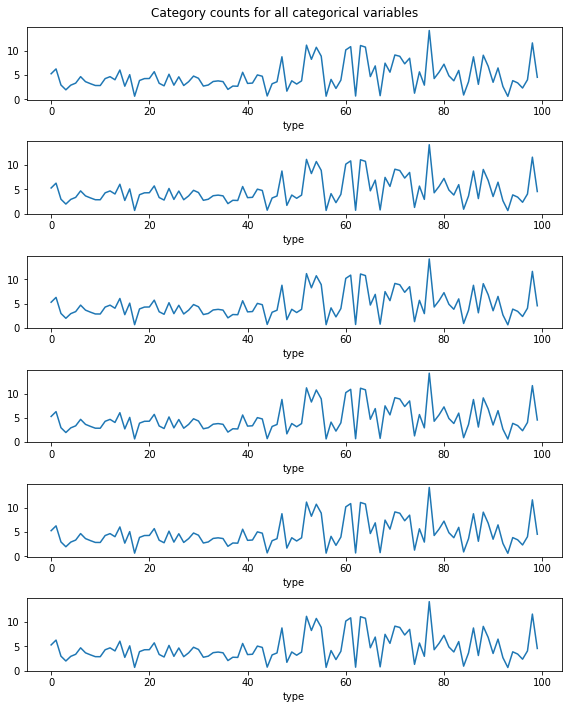

In [30]:
plt.figure(figsize=(8, 10))
for i, col in enumerate(["type", "type", "type", "type", "type", "type"]):
    ax = plt.subplot(6, 1, i+1)
    ax.plot(genes_means)
    # sns.countplot(data=df, x=col, ax=ax) 
    ax.set_xlabel(col)
plt.suptitle('Category counts for all categorical variables')
plt.tight_layout()

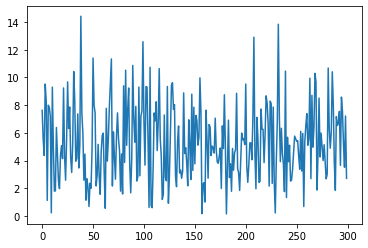

In [88]:
plt.plot(clean_expression[0,0,:])

## pca, umap

/tmp/ipykernel_24838/3726291228.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  anno = [np.array([str(x)] * 300, dtype=np.object) for x in range(9)]


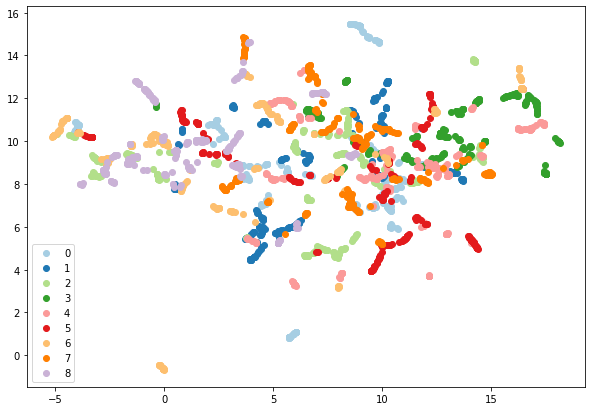

In [4]:
expr_clean = np.concatenate(clean_expression, axis = 1)
anno = [np.array([str(x)] * 300, dtype=np.object) for x in range(9)]
anno = np.concatenate(anno, axis = 0)

pca_op = PCA(n_components = 10, random_state=123)
# tsne_op = TSNE(n_components = 2)
umap_op = UMAP(n_components = 2, random_state=123) # , min_dist = 0.4, n_neighbors = 50)
counts_true = expr_clean.T
# counts_true = counts_true/np.sum(counts_true, axis = 1)[:, None] * 100
counts_true = np.log1p(counts_true)

x_pca = pca_op.fit_transform(counts_true)
x_umap = umap_op.fit_transform(x_pca)
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot()
colormap = plt.get_cmap("Paired")
for i, clust in enumerate(np.sort(np.unique(anno))):
    idx = np.where(anno == clust)[0]
    ax.scatter(x_umap[idx, 0], x_umap[idx, 1], color = colormap(i), label = clust)
ax.legend()

(100, 2700)


/tmp/ipykernel_24838/3283379225.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  anno = [np.array([str(x)] * 300, dtype=np.object) for x in range(9)]


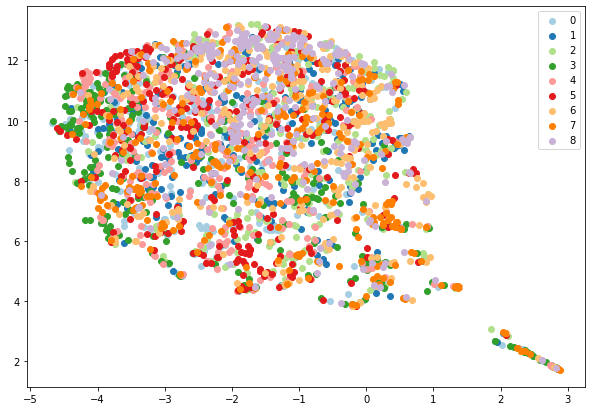

In [14]:
expr_add_outlier_genes = sim.outlier_effect(clean_expression, outlier_prob=0.01, mean=0.8, scale=1)
libFactor, expr_O_L = sim.lib_size_effect(expr_add_outlier_genes, mean=4.8, scale=0.3)
binary_ind = sim.dropout_indicator(expr_O_L, shape=20, percentile=82)
expr_O_L_D = np.multiply(binary_ind, expr_O_L)
count_matrix_umi_count_format = sim.convert_to_UMIcounts(expr_O_L_D)
noisy_expression = np.concatenate(count_matrix_umi_count_format, axis=1)
print(noisy_expression.shape)

expr_noisy = noisy_expression # np.concatenate(noisy_expression, axis = 1)
anno = [np.array([str(x)] * 300, dtype=np.object) for x in range(9)]
anno = np.concatenate(anno, axis = 0)

pca_op = PCA(n_components = 10, random_state=123)
umap_op = UMAP(n_components = 2, random_state=123) # , min_dist = 0.4, n_neighbors = 50)

counts = expr_noisy.T

# counts = counts/(np.sum(counts, axis = 1)[:, None] + 1e-6)* 100
# counts_true = np.log1p(counts)

x_pca = pca_op.fit_transform(counts_true)
x_umap = umap_op.fit_transform(x_pca)
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot()
colormap = plt.get_cmap("Paired")
for i, clust in enumerate(np.sort(np.unique(anno))):
    idx = np.where(anno == clust)[0]
    ax.scatter(x_umap[idx, 0], x_umap[idx, 1], color = colormap(i), label = clust)
ax.legend()

##  ours

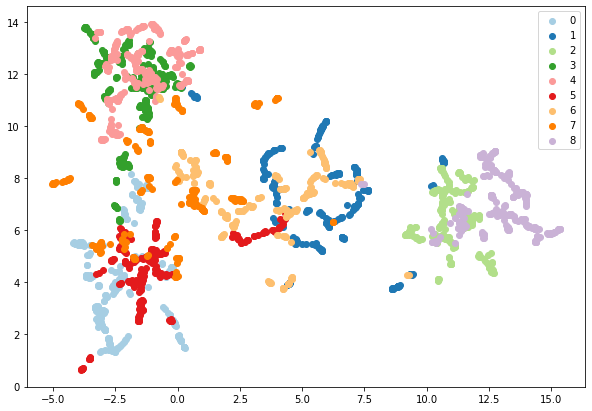

In [21]:
our_expr_clean = np.concatenate(expr_clean.T, axis = 1)
anno = [np.array([str(x)] * 300, dtype=object) for x in range(9)]
anno = np.concatenate(anno, axis = 0)

pca_op = PCA(n_components = 10, random_state=123)
umap_op = UMAP(n_components = 2, random_state=123) # , min_dist = 0.4, n_neighbors = 50)
counts_true = our_expr_clean.T

# counts = counts/(np.sum(counts, axis = 1)[:, None] + 1e-6)* 100
# counts_true = np.log1p(counts_true)

x_pca = pca_op.fit_transform(counts_true)
x_umap = umap_op.fit_transform(x_pca)

fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot()
colormap = plt.get_cmap("Paired")
for i, clust in enumerate(np.sort(np.unique(anno))):
    idx = np.where(anno == clust)[0]
    ax.scatter(x_umap[idx, 0], x_umap[idx, 1], color = colormap(i), label = clust)
ax.legend()
plt.show()